In [12]:
import nibabel as nib 
import numpy as np 
from matplotlib import pyplot as plt 
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
%matplotlib inline 
%load_ext rpy2.ipython

In [2]:
def plotUniStats(data, mask):
    """Plot bar graph with mean z-stat extracted from under given mask, mark individual observations with dots"""
    
    sns.set_style("white")
    sns.set_context("paper", font_scale = 2)

    g = sns.catplot(kind='bar', data=data[data['MASK']==mask], 
                    x='BODY_PART', y='Z-STAT', 
                    hue='SESS', ci=68, capsize=0.2, 
                edgecolor=".2", errcolor=".2", height=7, color='grey', order=list(data['BODY_PART'].unique()))

    backgroundartists = []
    ax1 = g.axes.flat[0]
    for l in ax1.lines + ax1.collections:
        l.set_zorder(1)
        backgroundartists.append(l)

    g.map(sns.stripplot, 'BODY_PART', 'Z-STAT', 'SESS', dodge="True", 
          size=5, alpha=0.7,
          order=list(data['BODY_PART'].unique()), hue_order=['pre', 'post'])

    for l in ax1.lines + ax1.collections:
        if l not in backgroundartists:
            l.set_zorder(5)

    plt.suptitle(mask)
    sns.despine(left=True, trim=True)
    g._legend.remove()
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    g.set(xlabel='')
    plt.show()
    

In [3]:
augmented = ['SF1', 'SF2', 'SF3', 'SF4', 'SF5', 'SF6', 'SF7', 'SF8', 'SF11', 'SF12', 'SF13', 'SF14', 'SF15', 
            'SF16', 'SF17', 'SF19', 'SF21', 'SF22', 'SF23', 'SF24']
#controls = ['CF1', 'CF2', 'CF4', 'CF5', 'CF6', 'CF7', 'CF8', 'CF9', 'CF10', 'CF11', 'CF12']
sessions = ['pre', 'post']

### 1. Get mean z-stat from under the masks

In [4]:
temp = []
allTemp = []

masks = ['LH200mask_highres', 'RH200mask_highres', 'BF200mask_highres']
stat = ['11', '12', '13', '14']
# 11: Feet
# 12: Lips
# 13: RHand
# 14: LHand

for m in masks:
    print(m.split('200')[0])
    for ses in sessions:
        for subj in augmented:
            for con in stat:
                mask = nib.load('../{}/masks/{}.nii.gz'.format(subj,m)).get_fdata()
                data = nib.load('../{}/{}/model/all-runs-highres.gfeat/cope{}.feat/stats/zstat1.nii.gz'.format(subj,ses,con)).get_fdata()
                zstat = data[mask > 0.3].mean()
                temp.append(zstat)
            allTemp.append([subj, ses, m.split('200')[0]] + temp)
            temp = []
            
ROI = pd.DataFrame(allTemp)
ROI = ROI.set_axis(['SUBJ', 'SESS', 'MASK', 'Feet', 'Lips', 'RHand', 'LHand'], axis='columns', inplace=False)


LH
RH
BF


In [23]:
ROI = ROI.melt(id_vars=['SUBJ', 'SESS', 'MASK'],
                  value_vars=['Feet', 'Lips', 'RHand', 'LHand'],
                  var_name='BODY_PART', value_name='ZSTAT')
ROI.head(10)

,SUBJ,SESS,MASK,BODY_PART,ZSTAT
0,SF1,pre,LH,Feet,-2.078110
1,SF2,pre,LH,Feet,1.856376
2,SF3,pre,LH,Feet,-0.151168
3,SF4,pre,LH,Feet,-1.078075
4,SF5,pre,LH,Feet,1.732775
5,SF6,pre,LH,Feet,-1.831696
6,SF7,pre,LH,Feet,-1.394652
7,SF8,pre,LH,Feet,-0.606911
8,SF11,pre,LH,Feet,1.964776
9,SF12,pre,LH,Feet,0.381869


### 2. Plots

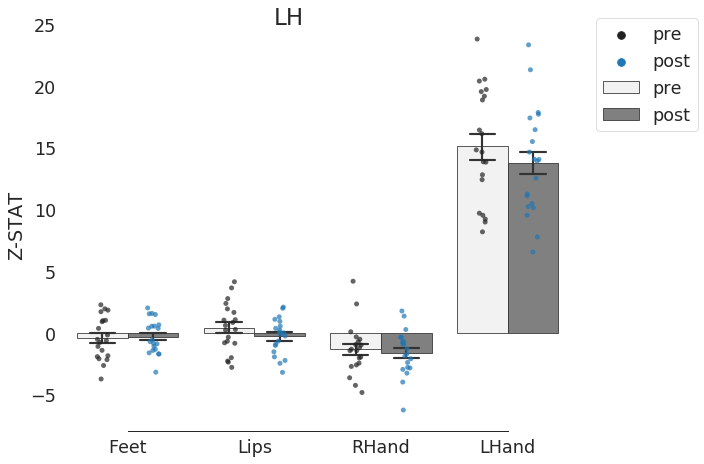

In [22]:
plotUniStats(ROI, 'LH')

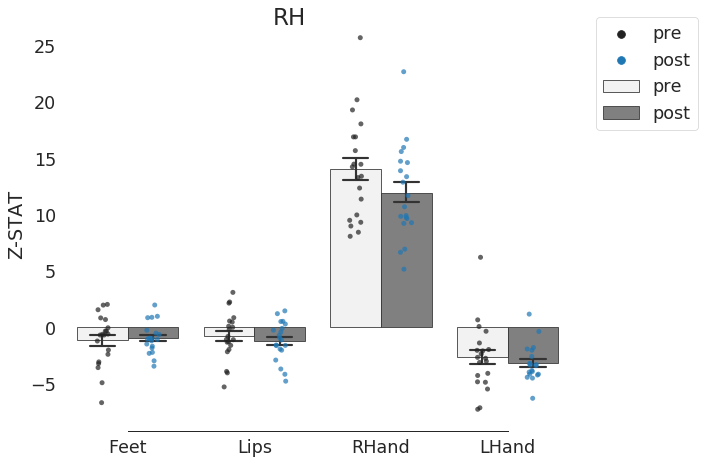

In [23]:
plotUniStats(ROI, 'RH')

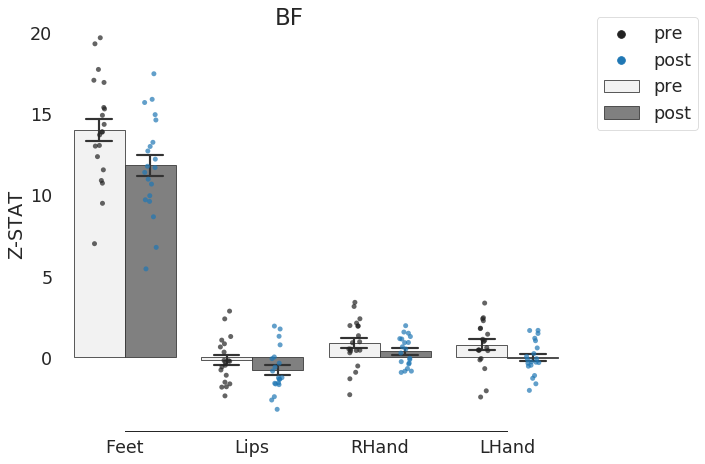

In [6]:
plotUniStats(ROI, 'BF')

In [7]:
ROI.to_csv('func-univariate.csv')

### 3. Stats

In [22]:
ROI = pd.read_csv('func-univariate.csv')

In [24]:
# Check for outliers
ROI['outlier'] = ROI.groupby(['SESS', 'MASK', 'BODY_PART'])['ZSTAT'].apply(lambda x: (x - x.mean()) > 3 * x.std())

In [25]:
ROI['outlier'].sum()

0

In [26]:
# Check normality
ROI.groupby(['SESS', 'MASK', 'BODY_PART'])['ZSTAT'].apply(lambda x: stats.shapiro(x)[1])

SESS  MASK  BODY_PART
post  BF    Feet         0.988431
            LHand        0.470299
            Lips         0.339325
            RHand        0.249408
      LH    Feet         0.441781
            LHand        0.791285
            Lips         0.872859
            RHand        0.811083
      RH    Feet         0.647183
            LHand        0.073690
            Lips         0.588697
            RHand        0.442021
pre   BF    Feet         0.982565
            LHand        0.519074
            Lips         0.584783
            RHand        0.803152
      LH    Feet         0.553476
            LHand        0.316177
            Lips         0.824511
            RHand        0.133631
      RH    Feet         0.323072
            LHand        0.082075
            Lips         0.825506
            RHand        0.256103
Name: ZSTAT, dtype: float64

#### 4. Hand specific activity pre vs post

We used a univariate approach to interrogate activity levels within the (independently localised) cortical territory of the biological hands. 

In [27]:
handStats = ROI.query('(BODY_PART == "RHand" and MASK == "RH") or (BODY_PART == "LHand" and MASK == "LH")')
handStats

,SUBJ,SESS,MASK,BODY_PART,ZSTAT,outlier
280,SF1,pre,RH,RHand,9.958282,False
281,SF2,pre,RH,RHand,16.872334,False
282,SF3,pre,RH,RHand,8.426405,False
283,SF4,pre,RH,RHand,11.361041,False
284,SF5,pre,RH,RHand,8.975019,False
...,...,...,...,...,...,...
395,SF19,post,LH,LHand,21.314975,False
396,SF21,post,LH,LHand,17.717506,False
397,SF22,post,LH,LHand,17.856974,False
398,SF23,post,LH,LHand,6.568783,False


In [28]:
%%R

library(lme4)
library(optimx)
library(afex)
library("rstatix")
library(emmeans)

In [30]:
%%R -i handStats

anovaModelRM <- aov_car(ZSTAT ~ MASK * SESS + Error(SUBJ/SESS*MASK), data=handStats)
anovaModelRM

Anova Table (Type 3 tests)

Response: ZSTAT
     Effect    df  MSE       F  ges p.value
1      SESS 1, 19 8.98  6.44 *  .04     .02
2      MASK 1, 19 4.85 9.17 **  .03    .007
3 SESS:MASK 1, 19 1.37    1.95 .002     .18
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘+’ 0.1 ‘ ’ 1


#### 4. Feet activity in augmented hand territory

We used a univariate approach to examine feet-specific activity within the augmented hand territory.

In [35]:
stats.ttest_rel(np.array(ROI.query('MASK == "RH" and BODY_PART == "Feet" and SESS == "pre"')['ZSTAT']), 
                np.array(ROI.query('MASK == "RH" and BODY_PART == "Feet" and SESS == "post"')['ZSTAT']))


Ttest_relResult(statistic=-0.47083307229832705, pvalue=0.6431203845727969)

#### 5. Augmented hand activity in feet teritory

In [39]:
stats.ttest_rel(np.array(ROI.query('MASK == "BF" and BODY_PART == "RHand" and SESS == "pre"')['ZSTAT']), 
                np.array(ROI.query('MASK == "BF" and BODY_PART == "RHand" and SESS == "post"')['ZSTAT']))

Ttest_relResult(statistic=1.589587172678317, pvalue=0.12842964295651374)

In [42]:
%%R -i ROI

anovaModelRM <- aov_car(ZSTAT ~ BODY_PART * SESS + Error(SUBJ/SESS*BODY_PART), 
                        data=subset(ROI, MASK == 'BF' & (BODY_PART == 'RHand' | BODY_PART == 'LHand')))
anovaModelRM

Anova Table (Type 3 tests)

Response: ZSTAT
          Effect    df  MSE      F  ges p.value
1           SESS 1, 19 1.90 4.58 *  .07     .05
2      BODY_PART 1, 19 0.28 4.47 *  .01     .05
3 SESS:BODY_PART 1, 19 0.24   1.84 .004     .19
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘+’ 0.1 ‘ ’ 1
